In [ ]:
import numpy as np
import struct
from array import array


In [44]:
#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
    
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test) 

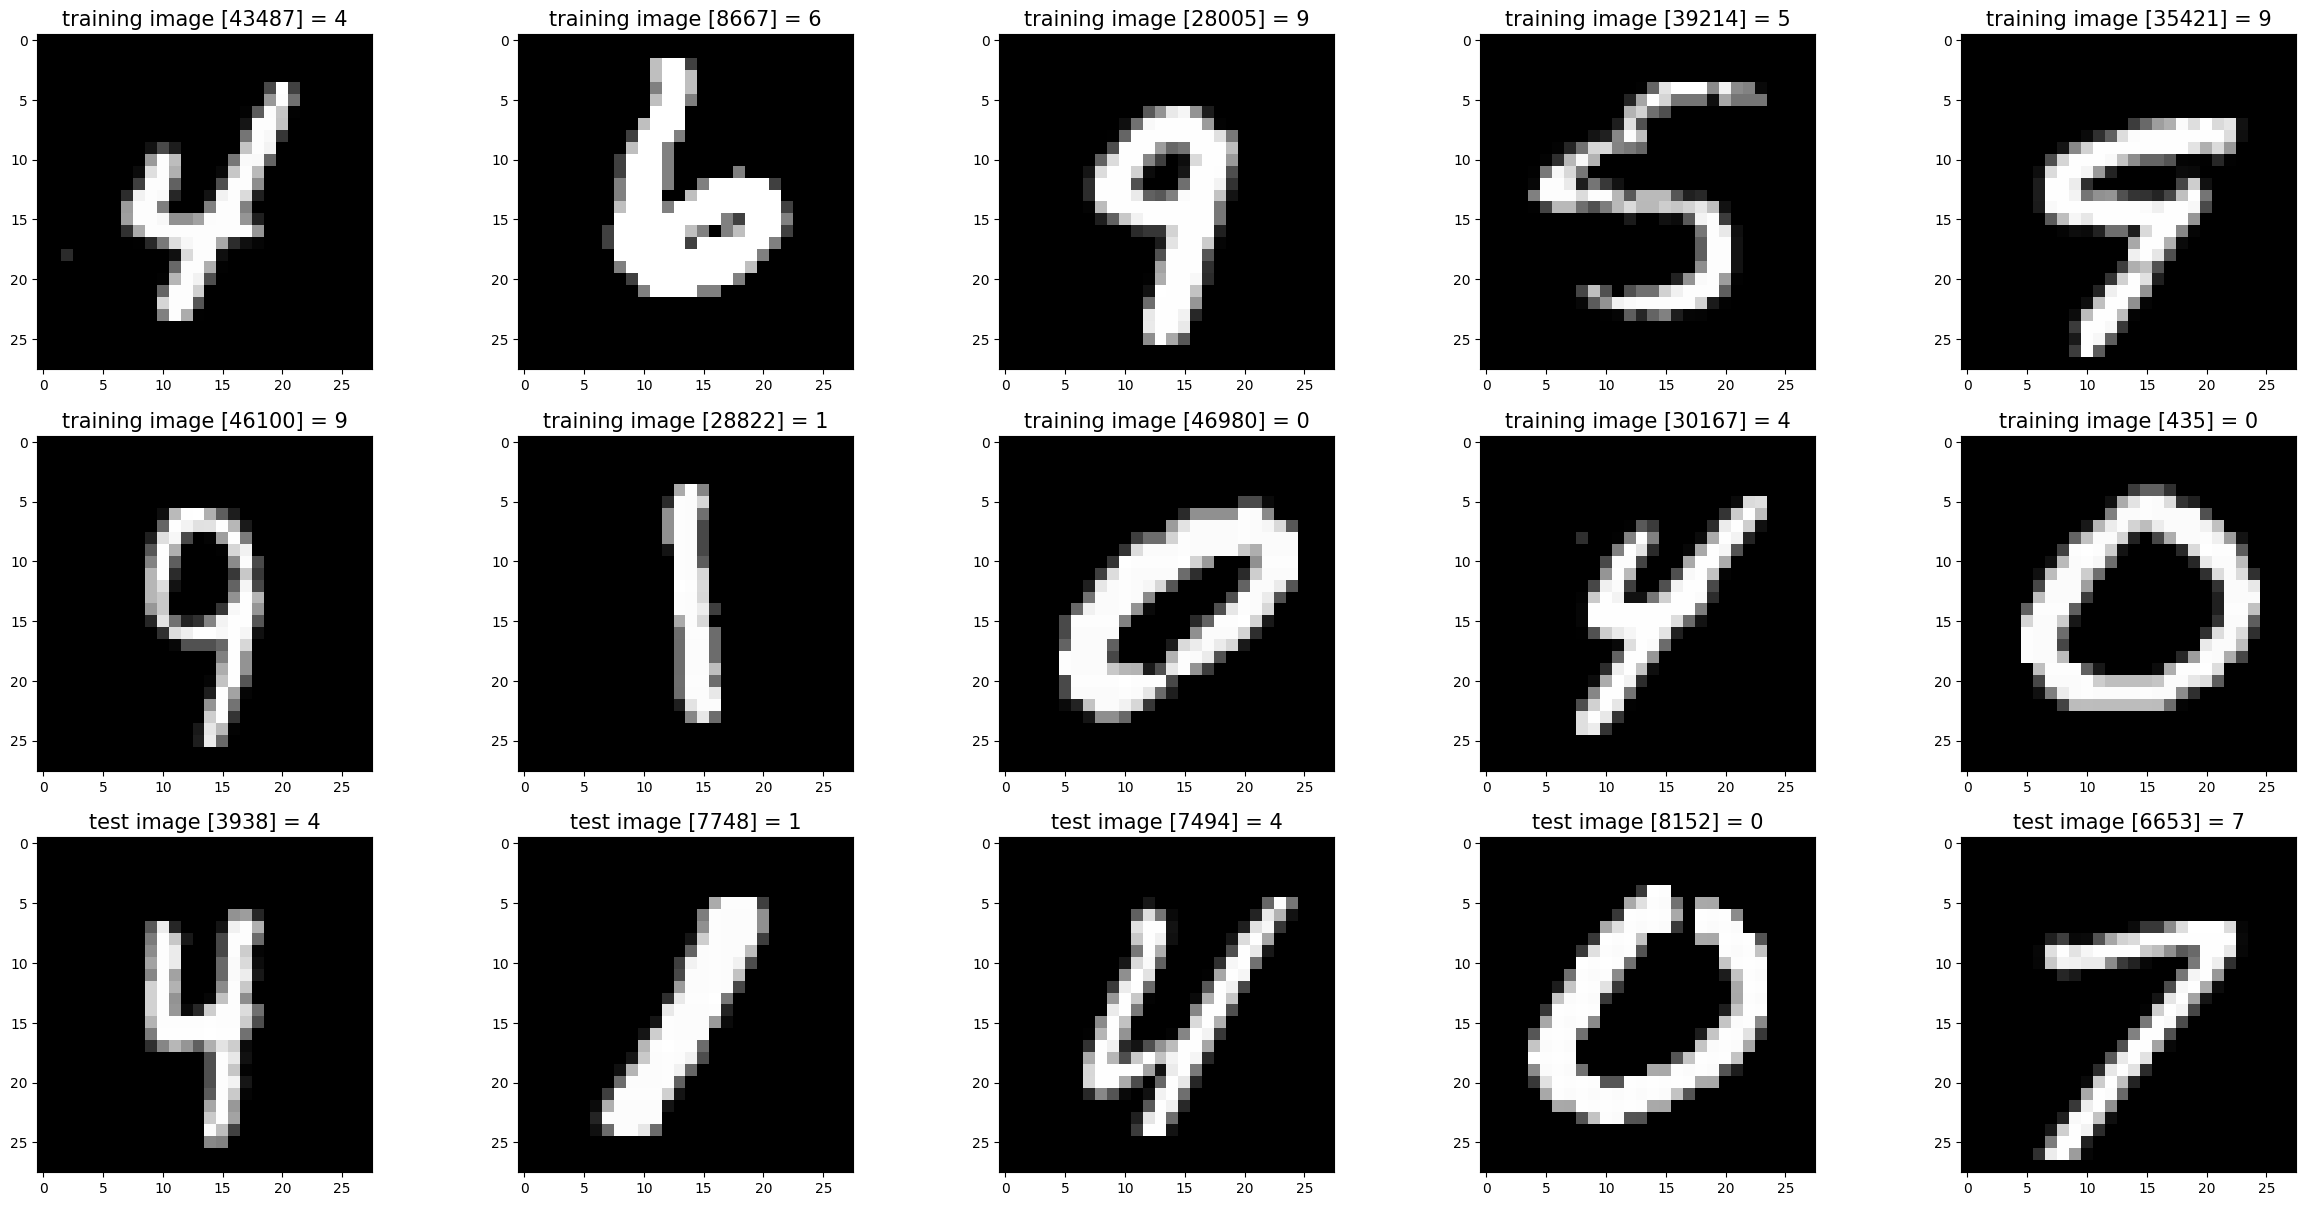

In [45]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
training_images_filepath = 'train-images-idx3-ubyte/train-images-idx3-ubyte'
training_labels_filepath = 'train-labels-idx1-ubyte/train-labels-idx1-ubyte'
test_images_filepath = 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte'
test_labels_filepath = 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte'

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [46]:
X_train = np.array(x_train).reshape(60000, 784).T  # (784, 60000)
print("Training Data Shape :-", X_train.shape)

X_test = np.array(x_test).reshape(10000, 784).T    # (784, 10000)
print("Testing Data Shape :-", X_test.shape)

Training Data Shape :- (784, 60000)
Testing Data Shape :- (784, 10000)


In [47]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [48]:
Y_train = np.array(y_train)
Y_test = np.array(y_test)

In [49]:
Y_train

array([5, 0, 4, ..., 5, 6, 8], shape=(60000,), dtype=uint8)

In [50]:
_,size_of_test = X_test.shape
_,size_of_train = X_train.shape

In [51]:
m = size_of_train + size_of_test

In [52]:
m

70000

In [53]:
def initial_values():
    W1 = np.random.rand(24, 784) - 0.5
    b1 = np.random.rand(24, 1) - 0.5

    W2 = np.random.rand(10, 24) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

In [54]:
def relu(Z):
    return np.maximum(Z, 0)

In [55]:
def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))  # for numerical stability
    return expZ / np.sum(expZ, axis=0, keepdims=True)

In [56]:
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = relu(Z1)
    
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

In [57]:
def relu_deriv(Z):
    return (Z > 0).astype(float)

In [58]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [ ]:
def back_prop(Z1, A1, A2, W2, X, Y):
    one_hot_Y = one_hot(Y)
    m = X.shape[1]
    
    deriv_Z2 = A2 - one_hot_Y
    deriv_W2 = 1 / m * deriv_Z2.dot(A1.T)
    deriv_b2 = 1 / m * np.sum(deriv_Z2, axis=1, keepdims=True)

    deriv_Z1 = W2.T.dot(deriv_Z2) * relu_deriv(Z1)
    deriv_W1 = 1/ m * deriv_Z1.dot(X.T)
    deriv_b1 = 1 / m * np.sum(deriv_Z1, axis=1, keepdims=True)

    return deriv_W1, deriv_b1, deriv_W2, deriv_b2
     

In [60]:
def update_weigths(W1, b1, W2, b2, deriv_W1, deriv_b1, deriv_W2, deriv_b2, learning_rate):
    W1 = W1 - learning_rate * deriv_W1
    b1 = b1 - learning_rate * deriv_b1
    W2 = W2 - learning_rate * deriv_W2
    b2 = b2 - learning_rate * deriv_b2
    return W1,b1,W2,b2

In [61]:
def prediction(A2):
    return np.argmax(A2, 0)
def accuracy(prediction, Y):
    print(prediction, Y)
    return np.sum(prediction == Y) / Y.size

In [62]:
def main(X, Y, learning_rate, iterations):
    W1, b1, W2, b2 = initial_values()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)

        deriv_W1, deriv_b1, deriv_W2, deriv_b2 = back_prop(Z1, A1, Z2, A2, W1, W2, X, Y)

        W1, b1, W2, b2 = update_weigths(W1, b1, W2, b2, deriv_W1, deriv_b1, deriv_W2,deriv_b2, learning_rate)
        if i % 10 == 0:
            print("Iteration: ", i)
            pred = prediction(A2)
            print("Accuracy := ",accuracy(pred, Y), "\n")
    return W1, b1, W2, b2

In [64]:
W1, b1, W2, b2 = main(X_train, Y_train, .2, 500)

Iteration:  0
[4 4 4 ... 4 2 4] [5 0 4 ... 5 6 8]
Accuracy :=  0.11805 

Iteration:  10
[6 0 0 ... 5 2 6] [5 0 4 ... 5 6 8]
Accuracy :=  0.45221666666666666 

Iteration:  20
[6 0 4 ... 5 2 6] [5 0 4 ... 5 6 8]
Accuracy :=  0.6087333333333333 

Iteration:  30
[6 0 4 ... 5 2 0] [5 0 4 ... 5 6 8]
Accuracy :=  0.6832 

Iteration:  40
[8 0 4 ... 5 2 0] [5 0 4 ... 5 6 8]
Accuracy :=  0.72715 

Iteration:  50
[5 0 4 ... 5 2 0] [5 0 4 ... 5 6 8]
Accuracy :=  0.75535 

Iteration:  60
[5 0 4 ... 5 6 0] [5 0 4 ... 5 6 8]
Accuracy :=  0.7756333333333333 

Iteration:  70
[5 0 4 ... 5 6 0] [5 0 4 ... 5 6 8]
Accuracy :=  0.7911333333333334 

Iteration:  80
[5 0 4 ... 5 6 0] [5 0 4 ... 5 6 8]
Accuracy :=  0.8037166666666666 

Iteration:  90
[5 0 4 ... 5 6 0] [5 0 4 ... 5 6 8]
Accuracy :=  0.8141333333333334 

Iteration:  100
[5 0 4 ... 5 6 0] [5 0 4 ... 5 6 8]
Accuracy :=  0.8232833333333334 

Iteration:  110
[5 0 4 ... 5 6 0] [5 0 4 ... 5 6 8]
Accuracy :=  0.8305333333333333 

Iteration:  120
[5 0 4 

In [70]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = prediction(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [5]
Label:  5


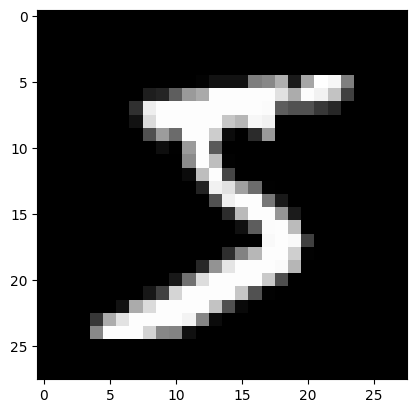

Prediction:  [0]
Label:  0


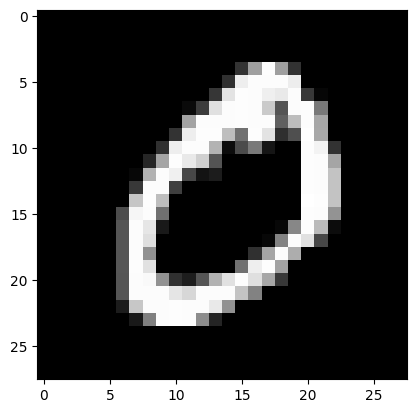

Prediction:  [4]
Label:  4


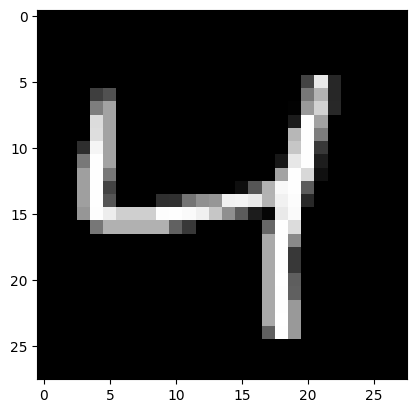

Prediction:  [1]
Label:  1


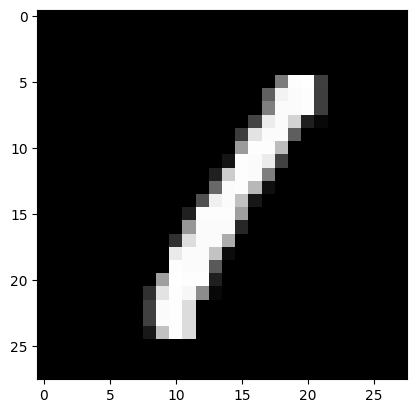

In [71]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

In [72]:
dev_predictions = make_predictions(X_test, W1, b1, W2, b2)
accuracy(dev_predictions, Y_test)

[7 2 1 ... 4 5 6] [7 2 1 ... 4 5 6]


np.float64(0.9064)